In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Network Science Analytics
Community Detection
"""
from helper import *
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

In [2]:
# Read Karate network
karate = nx.read_gml("./karate.gml")
# Read toy graph
toygraph = nx.read_gml("./3net.gml")

In [3]:
# Please specify the network which you would like to work
G = karate # Possible choices: toygraph - karate 

number of edges 78
number of nodes 34
min degree 1
max degree 17
Is connected ? True
number of connected components:  1


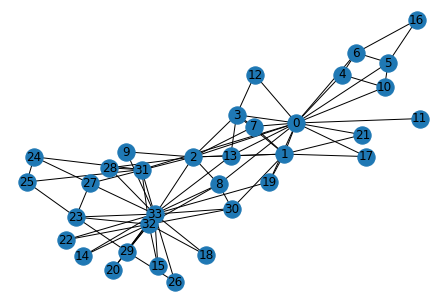

In [4]:
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    #print('VERTICES', G.nodes())
    #print('EDGES', G.edges())
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
    nx.draw(G, with_labels =True)

GetInfoGraph(G)

### Part I: Girvan–Newman Algorithm

##### Exercise 1: Implementation of Girvan-Newman Algorithm

In [5]:
# Exercise 1.1
def girvan_newman_algorithm(G):
    '''
    :param G: given graph
    :return partitions: a list tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    '''
    g = G.copy()
    partitions = []
    size=1
    
    # Repeat below process until one edge left
    while len(g.edges) > 0:
        
        # Compute betweeness centrality for every edges - use shortest path 
        ebc = nx.edge_betweenness_centrality(g)
    
        # Remove edge with highest centrality
        edge = max(ebc, key=ebc.get)
        g.remove_edge(edge[0], edge[1]) 
    
        # Retrieve communities with this edge removal
        # communities = [c for c in sorted(nx.connected_components(g), key=len, reverse=True)]
        communities = list(nx.connected_components(g))
        
        # Update partitions if communities have changed
        if len(communities) != size: 
            partitions.append(communities)
            size += 1
        
    # Use below dendograms to learn when to stop 
    return partitions

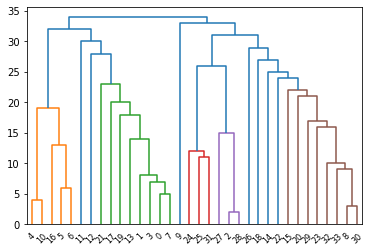

In [6]:
# Exercise 1.2
partitions = girvan_newman_algorithm(G)
plot_dendrogram(G, partitions)

#### Exercise 2: Implementation of modularity function

In [30]:
# Exercise 2.1
def compute_modularity(G, partition):
    '''
    :param G: given graph
    :param partition: a tuple of node sets.
    :return result: modularity value for a given partition of the network.
    '''    
    num_of_edges = G.number_of_edges()
    modularity_list = []
    
    # Loop over communities
    for subset in partition:
        nodelist = list(subset)
        G_subset = G.subgraph(nodelist)
        A = nx.adj_matrix(G_subset)
        
        s = 0
        # For all pair of nodes inside these communities
        for i in range(G_subset.number_of_nodes()):
            for j in range(G_subset.number_of_nodes()):
                s += A[i, j] - ( ( nx.degree(G, nodelist[i])*nx.degree(G, nodelist[j]) ) / (2.0*num_of_edges) )
            
        modularity_list.append(s / (2.0*num_of_edges))
            
    return np.sum(modularity_list)

In [31]:
# Exercise 2.2
# Print modularity scores
for partition in partitions:
    print(len(partition), compute_modularity(G, partition))

2 0.3599605522682441
3 0.3487836949375409
4 0.3632478632478631
5 0.40129848783694966
6 0.39250493096646966
7 0.3762327416173573
8 0.3583168967784355
9 0.34171597633136114
10 0.33284023668639073
11 0.3159105851413545
12 0.29865220249835644
13 0.28040762656147283
14 0.262820512820513
15 0.24490466798159102
16 0.22633136094674555
17 0.2056213017751479
18 0.18984220907297833
19 0.1655161078238001
20 0.15548980933596315
21 0.1469428007889546
22 0.1228632478632479
23 0.09853714661406972
24 0.07511505588428666
25 0.06377383300460224
26 0.05095332018408941
27 0.03788625904010518
28 0.01865548980933596
29 0.002876397107166336
30 -0.008629191321499015
31 -0.01619000657462196
32 -0.02827087442472058
33 -0.03944773175542407
34 -0.049802761341222884


In [32]:
# Now combine both girvan_newman_algorithm and modularity
best_partition = -100 
for partition in partitions:
    mod = compute_modularity(G, partition)
    if mod > best_partition:
        best_partition = mod
        com = partition
print(com)

[{'11', '12', '21', '19', '3', '0', '17', '7', '13', '1'}, {'32', '18', '20', '15', '14', '23', '8', '26', '22', '33', '30', '29'}, {'6', '16', '4', '10', '5'}, {'28', '25', '24', '27', '31', '2'}, {'9'}]


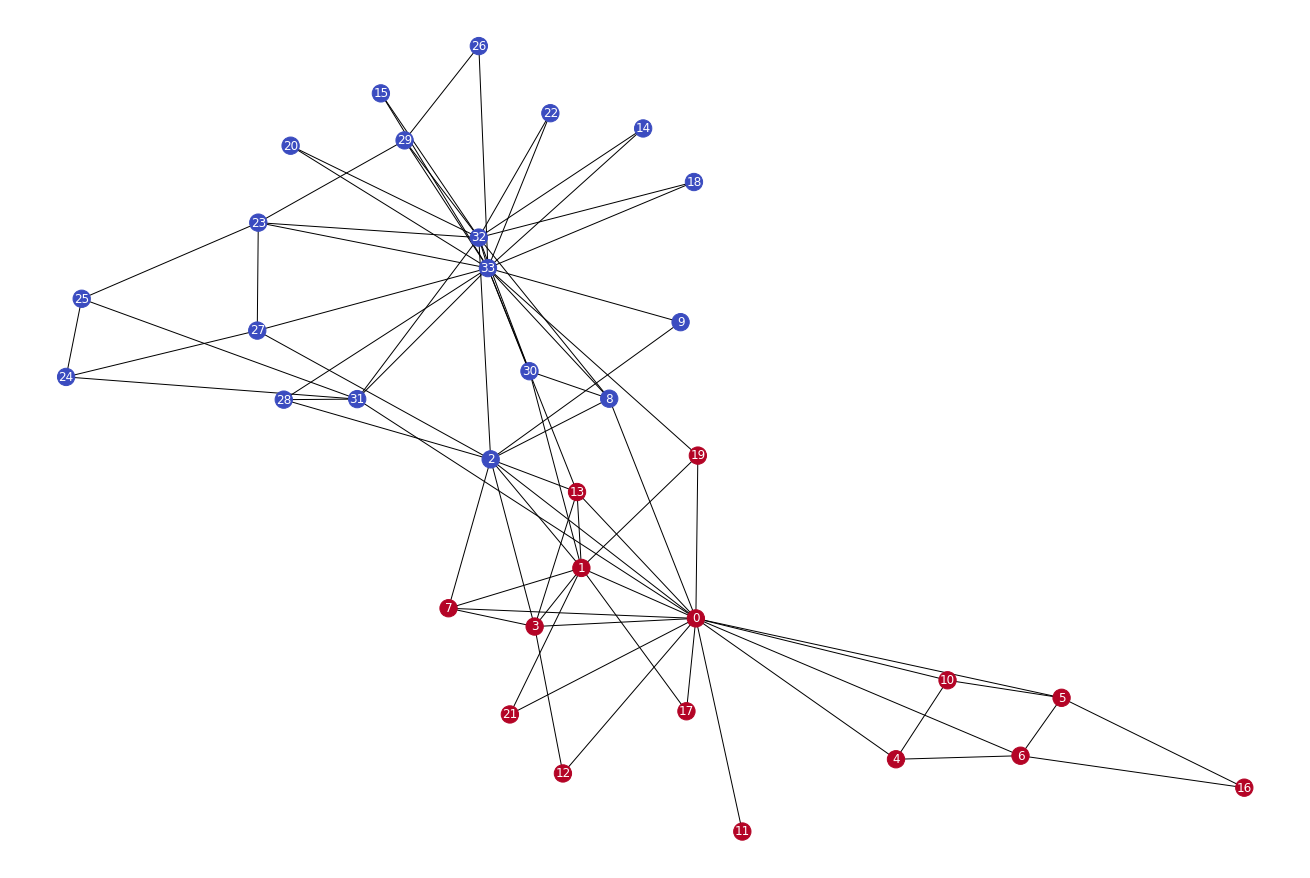

In [33]:
# Exercise 2.3 
# PLOTS 

# Choose 2 partition into 2 communities
# Define set of vertices 
A = list(partitions[0][0])
B = list(partitions[0][1])
val_map=[]

# Attribute a value to each cluster
for node in G.nodes():
    if node in A: val_map.append(1)   
    else: val_map.append(0) 

# Plot params
plt.figure(figsize=(18, 12))
layout = nx.fruchterman_reingold_layout(G)
nx.draw(G, node_color= val_map, pos =layout, with_labels=True, font_color='white', cmap=plt.cm.coolwarm)
plt.savefig('karate_cluster.png')

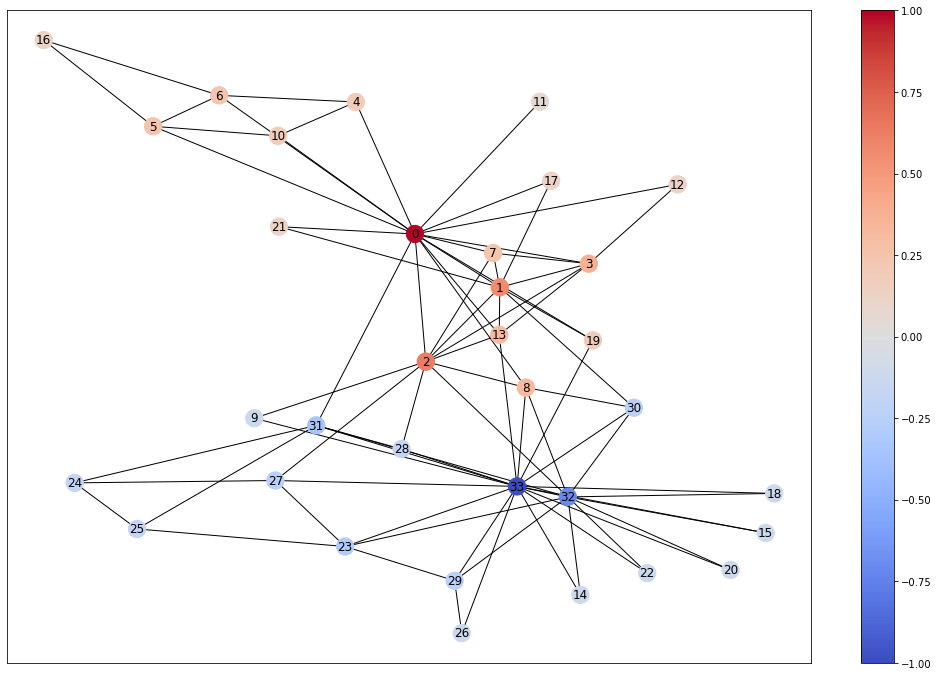

In [34]:
# PLOT 2
G = nx.karate_club_graph()

df = (pd.DataFrame(list(G.degree), columns=['node','degree'])
        .set_index('node'))
df['club'] = pd.Series({node:data['club']
                        for node,data in G.nodes(data=True)})
df['color'] = df.groupby('club')['degree'].transform(lambda c: c/c.max())
df.loc[df['club']=='Officer', 'color'] *= -1

plt.figure(figsize=(18, 12))
layout = nx.fruchterman_reingold_layout(G)
vmin = df['color'].min()
vmax = df['color'].max()
cmap = plt.cm.coolwarm

nx.draw_networkx(G, pos=layout, with_labels=True, node_color=df['color'],
                 cmap=cmap, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.savefig('karate_cluster&degree.png')

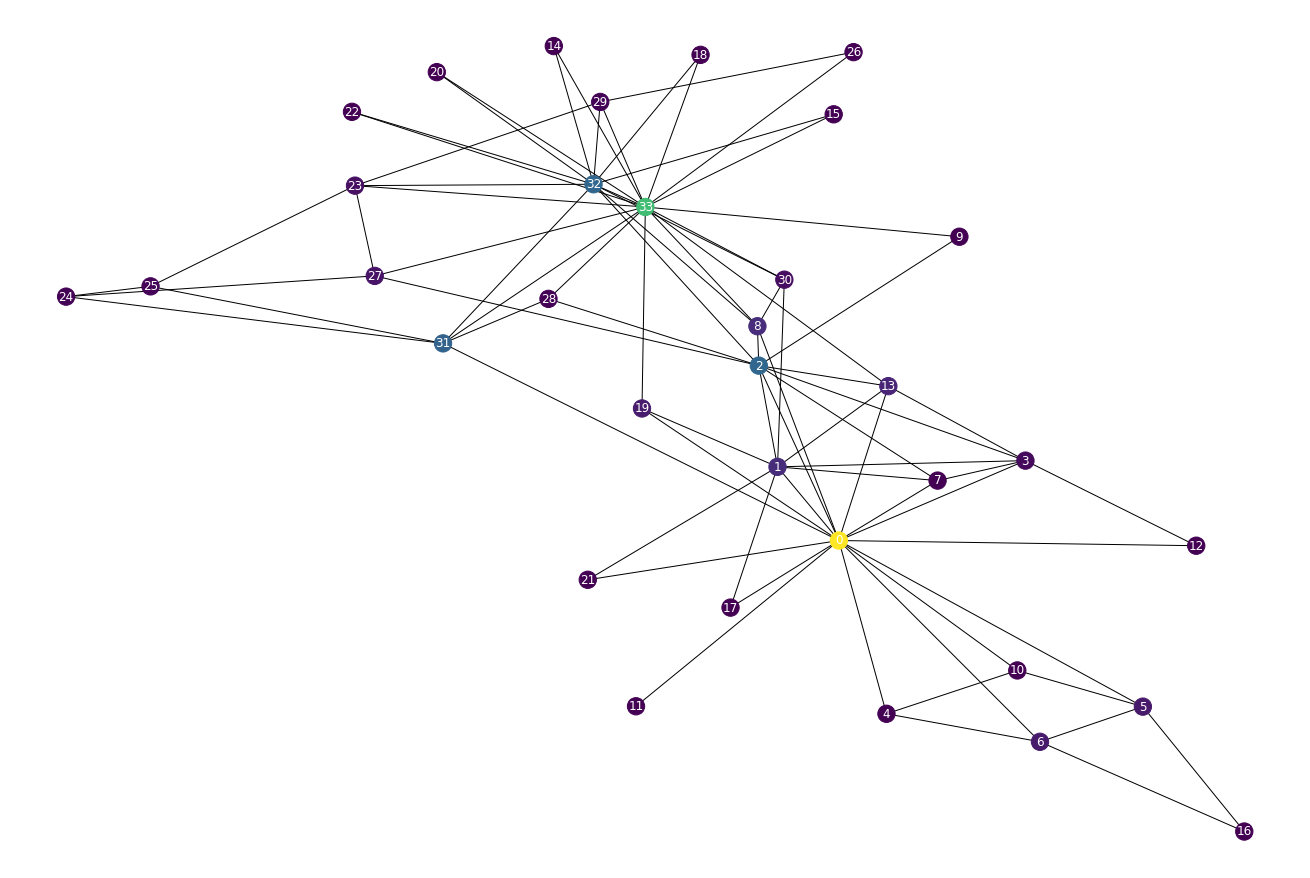

In [36]:
# PLOT3

# Betweenness Centrality of nodes
c_betweenness = nx.betweenness_centrality(G)
c_betweenness = list(c_betweenness.values())
plt.figure(figsize=(18, 12))

nx.draw(G, node_color = c_betweenness, with_labels=True, font_color='white')

### Part II: Spectral Clustering

#### Exercise 1: Implementation of Spectral Clustering

In [37]:
# Exercise 1.1
def spectral_clustering(G, k):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    
    # For a given undirected connected graph
    
    nodelist = list(G)  # keep the node orders
    A = np.array(nx.adjacency_matrix(G, nodelist).todense())
    D = np.diag(np.sum(A, axis=1))
    L = D - A # Laplacian matrix
    
    eigvals, eigvects = np.linalg.eig(L)
    # Sort the eigenvectors corresponding to their eigenvalues
    idx = np.argsort(eigvals)
    # eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    # Retrieve top k eigenvectors wrt eigenvalue
    X = eigvects[:, 0:k]
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[kmeans.labels_[i]].add(nodelist[i])
            
    return partition
    

In [38]:
# Exercise 2.2
spectral_partition = spectral_clustering(G, k=2)
girvan_newman_partition = girvan_newman_algorithm(G)[0]
print(compute_modularity(G, spectral_partition), compute_modularity(G, girvan_newman_partition))

0.2339743589743592 0.35996055226824464


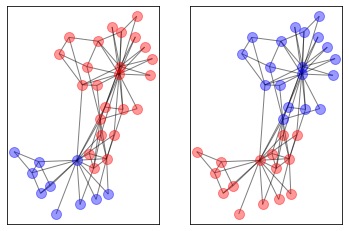

In [39]:
# Exercise 2.3
spectral_partition = spectral_clustering(G, k=2)
girvan_newman_partition = girvan_newman_algorithm(G)[0]
visualize(G, spectral_partition,  girvan_newman_partition)